In [2]:
import pandas as pd


df = pd.read_csv("C:/Users/mmrha/Desktop/cmu/Independent study/python/winemin.csv")
print(df.head())

   fixed.acidity  volatile.acidity  citric.acid  residual.sugar  chlorides  \
0            6.2             0.450         0.26             4.4      0.063   
1            9.8             0.360         0.46            10.5      0.038   
2            5.5             0.485         0.00             1.5      0.065   
3            6.4             0.595         0.14             5.2      0.058   
4            7.6             0.480         0.37             0.8      0.037   

   free.sulfur.dioxide  total.sulfur.dioxide  density    pH  sulphates  \
0                 63.0                 206.0   0.9940  3.27       0.52   
1                  4.0                  83.0   0.9956  2.89       0.30   
2                  8.0                 103.0   0.9940  3.63       0.40   
3                 15.0                  97.0   0.9951  3.38       0.36   
4                  4.0                 100.0   0.9902  3.03       0.39   

   alcohol  
0      9.8  
1     10.1  
2      9.7  
3      9.0  
4     11.4  


In [3]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras import backend as K


latent_dimension = 1
batch_size = 20
hidden_nodes = 16


input_encoder = Input(shape=(11,), name="Input_Encoder")
batch_normalize1 = BatchNormalization()(input_encoder)
hidden_layer = Dense(hidden_nodes, activation="relu", name="Hidden_Encoding")(
    batch_normalize1
)
batch_normalize2 = BatchNormalization()(hidden_layer)
z = Dense(latent_dimension, name="Mean")(batch_normalize2)

In [4]:
from keras import Model


encoder = Model(input_encoder, z)

In [5]:
input_decoder = Input(shape=(latent_dimension,), name="Input_Decoder")
batch_normalize1 = BatchNormalization()(input_decoder)
decoder_hidden_layer = Dense(hidden_nodes, activation="relu", name="Hidden_Decoding")(
    batch_normalize1
)
batch_normalize2 = BatchNormalization()(decoder_hidden_layer)
decoded = Dense(11, activation="linear", name="Decoded")(batch_normalize2)

In [6]:
decoder = Model(input_decoder, decoded, name="Decoder")

In [7]:
encoder_decoder = decoder(encoder(input_encoder))

ae = Model(input_encoder, encoder_decoder)
ae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Encoder (InputLayer)   [(None, 11)]              0         
_________________________________________________________________
model (Functional)           (None, 1)                 317       
_________________________________________________________________
Decoder (Functional)         (None, 11)                287       
Total params: 604
Trainable params: 516
Non-trainable params: 88
_________________________________________________________________


In [10]:
from tensorflow.random import set_seed


set_seed(2021)
ae.compile(loss="mean_squared_error", optimizer="adam")
history = ae.fit(
    df, df, shuffle=True, epochs=1500, batch_size=50, validation_split=0.2, verbose=0
).history

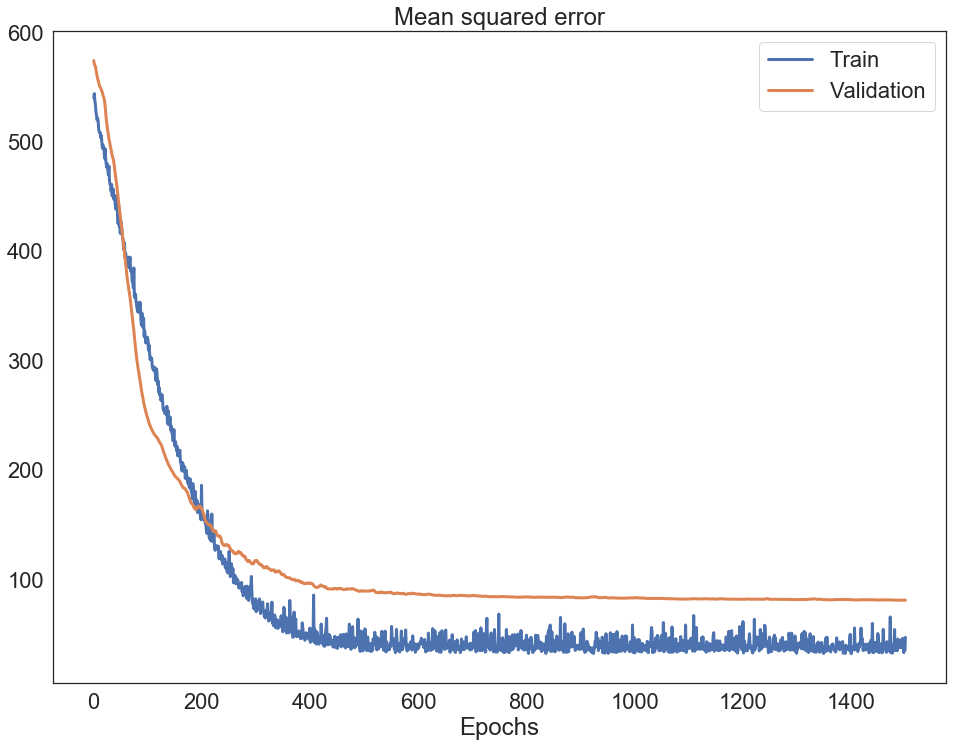

Training MSE = 6.8594956789284645
Validation MSE = 9.002677519196633


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(font_scale=2)
sns.set_style("white")


def model_analysis(history):
    train_loss = history["loss"]
    val_loss = history["val_loss"]
    t = np.linspace(1, len(train_loss), len(train_loss))

    plt.figure(figsize=(16, 12))
    plt.title("Mean squared error")
    sns.lineplot(x=t, y=train_loss, label="Train", linewidth=3)
    sns.lineplot(x=t, y=val_loss, label="Validation", linewidth=3)
    plt.xlabel("Epochs")

    plt.legend()
    plt.savefig("FirstNet.png", dpi=400)
    plt.show()
    print(f"Training MSE = {np.sqrt(train_loss[-1])}")
    print(f"Validation MSE = {np.sqrt(val_loss[-1])}")


model_analysis(history)

In [12]:
origin = pd.DataFrame(ae.predict(df))
origin.columns = df.columns
ae.predict(df)[0,:]

array([7.29260731e+00, 3.63089085e-01, 3.27665895e-01, 7.54554319e+00,
       1.08442105e-01, 5.01831360e+01, 2.09769806e+02, 9.88861263e-01,
       3.18204594e+00, 4.72830951e-01, 9.80432606e+00], dtype=float32)

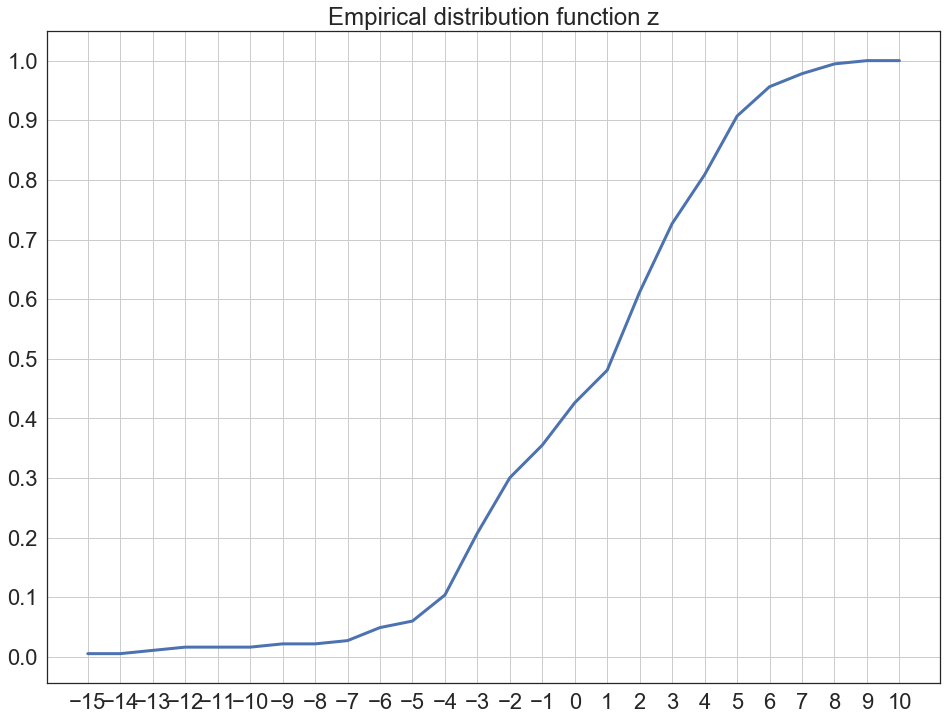

In [14]:
from statsmodels.distributions.empirical_distribution import ECDF


ecdf = ECDF(encoder.predict(df)[:, 0])
plt.figure(figsize=(16, 12))
plt.title("Empirical distribution function z")
x = (-15 ,-14, -13,-12,-11,-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10)
plt.yticks(np.linspace(0, 1, 11))
plt.xticks(x)
plt.grid()
plt.plot(x, ecdf(x), linewidth=3)
plt.savefig("EmpiricalDF.png", dpi=400)

In [15]:
from scipy.interpolate import interp1d


x = (-15 ,-14, -13,-12,-11,-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10)
sample_edf_values_at_slope_changes = [ecdf(i) for i in x]
inverted_edf = interp1d(sample_edf_values_at_slope_changes, x)

In [16]:
from numpy.random import uniform
from numpy.random import seed
N = 10000


output = pd.DataFrame(decoder(inverted_edf(uniform(0.02, 0.95, N))).numpy())
output.columns = df.columns

print(output)

      fixed.acidity  volatile.acidity  citric.acid  residual.sugar  chlorides  \
0          7.459406          0.329680     0.305758        2.874521   0.095480   
1          7.096070          0.331120     0.322434        4.841568   0.107102   
2          7.067829          0.340406     0.327723        6.050004   0.110143   
3          7.217947          0.355556     0.327685        7.048827   0.109007   
4          7.463558          0.329663     0.305569        2.852069   0.095347   
...             ...               ...          ...             ...        ...   
9995       7.158564          0.349562     0.327700        6.653688   0.109456   
9996       7.525594          0.329419     0.302721        2.516220   0.093362   
9997       7.349796          0.330115     0.310788        3.467941   0.098986   
9998       7.059884          0.331263     0.324093        5.037487   0.108261   
9999       7.557480          0.329293     0.301257        2.343547   0.092344   

      free.sulfur.dioxide  

In [17]:
output.to_csv("C:/Users/mmrha/Desktop/cmu/Independent study/python/wineauto3000_10000.csv")

In [18]:
origin

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol
0,7.292607,0.363089,0.327666,7.545543,0.108442,50.183136,209.769806,0.988861,3.182046,0.472831,9.804326
1,7.362899,0.330063,0.310188,3.397027,0.098568,10.048120,81.852371,0.982086,3.124432,0.384872,10.520335
2,7.258126,0.330477,0.314996,3.964231,0.101918,15.732925,100.136833,0.983346,3.142854,0.403966,10.155497
3,7.279417,0.330394,0.314019,3.848988,0.101239,14.577876,96.421753,0.983090,3.139113,0.400087,10.229629
4,7.275982,0.330407,0.314176,3.867568,0.101349,14.764109,97.020760,0.983132,3.139713,0.400714,10.217671
...,...,...,...,...,...,...,...,...,...,...,...
178,7.111027,0.331060,0.321746,4.760593,0.106624,23.714415,125.808304,0.985118,3.168717,0.430774,9.643263
179,7.272195,0.330423,0.314350,3.888062,0.101468,14.969519,97.681442,0.983177,3.140378,0.401401,10.204486
180,7.456665,0.329692,0.305885,2.889374,0.095567,4.960216,65.487762,0.980955,3.107942,0.367782,10.846858
181,7.565342,0.329263,0.300897,2.301021,0.092091,-0.936529,46.521614,0.979647,3.088834,0.347976,11.225298


In [19]:
df

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol
0,6.2,0.450,0.26,4.40,0.063,63.0,206.0,0.99400,3.27,0.52,9.8
1,9.8,0.360,0.46,10.50,0.038,4.0,83.0,0.99560,2.89,0.30,10.1
2,5.5,0.485,0.00,1.50,0.065,8.0,103.0,0.99400,3.63,0.40,9.7
3,6.4,0.595,0.14,5.20,0.058,15.0,97.0,0.99510,3.38,0.36,9.0
4,7.6,0.480,0.37,0.80,0.037,4.0,100.0,0.99020,3.03,0.39,11.4
...,...,...,...,...,...,...,...,...,...,...,...
178,7.1,0.240,0.34,1.20,0.045,6.0,132.0,0.99132,3.16,0.46,11.2
179,6.0,0.590,0.00,0.80,0.037,30.0,95.0,0.99032,3.10,0.40,10.9
180,6.0,0.350,0.46,0.90,0.033,9.0,65.0,0.98934,3.24,0.35,12.1
181,5.2,0.405,0.15,1.45,0.038,10.0,44.0,0.99125,3.52,0.40,11.6
